In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import math
import read_nd2
from cell import Cell
import pandas as pd

In [2]:
# set working directory
print(os.getcwd())
folder_path = "../src"

if os.path.exists(folder_path) and os.path.isdir(folder_path):
    # Change the current working directory to the specified folder
    os.chdir(folder_path)
    print(f"Current working directory set to: {folder_path}")
else:
    print(f"The folder '{folder_path}' does not exist.")

/Users/grace/Desktop/CSCI6118/Cell-Tracking/src
Current working directory set to: ../src


In [3]:
# function to check if pixel is within a contour - is flourescence within a cell

def is_pixel_inside_contour(pixel, contour):
    """
    Checks if a pixel is inside a contour.

    Args:
        pixel: A tuple (x, y) representing the pixel's coordinates.
        contour: A list of contour points, obtained from cv2.findContours.

    Returns:
        True if the pixel is inside the contour, False otherwise.
    """
    x, y = pixel
    point = (x, y)
    return cv2.pointPolygonTest(contour, point, False) >= 0



In [4]:
# # downscale image
# scale_percent = 60 # percent of original size
# width = int(image.shape[1] * scale_percent / 100)
# height = int(image.shape[0] * scale_percent / 100)
# dim = (width, height)

# #

In [5]:
# function to get the center of a contour
def get_center(contour):
    # Calculate moments for the contour
    M = cv2.moments(contour)

    # Calculate the centroid (center) of the contour
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
    else:
        cx, cy = 0, 0  # Handle division by zero if the contour has no area

    # add centroid to list of cell centers
    return((cx,cy))

In [6]:
# read the image
#image = cv2.imread('pngs/cells_C0_T178.png')

# function to segment an image with watershedding
# input: image to segment
# output: list of cells (1 for each cell)
def do_watershed(img):
    # img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    # convert to grayscale
    grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # threshold image 
    thresh = cv2.threshold(grayscale,0,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    
    # get sure background area
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    sure_bg = cv2.dilate(thresh, kernel, iterations=3) 
    
    # Distance transform
    dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)

    # get foreground area
    ret, sure_fg = cv2.threshold(dist, 0.2 * dist.max(), 255, cv2.THRESH_BINARY)
    sure_fg = sure_fg.astype(np.uint8) 
    
    # get unknown area
    unknown = cv2.subtract(sure_bg, sure_fg)
    
    # connected components
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers.astype(np.int32)
    # Add one to all labels so that background is not 0, but 1
    markers += 1
    # mark the region of unknown with zero
    markers[unknown == 255] = 0
    
    # apply watershed algorithm
    markers = cv2.watershed(img, markers)
    
    labels = np.unique(markers)

    cells = []
    for label in labels[2:]:
        # Create a binary image in which only the area of the label is in the foreground 
        # and the rest of the image is in the background   
        target = np.where(markers == label, 255, 0).astype(np.uint8)

        # Perform contour extraction on the created binary image
        contours, hierarchy = cv2.findContours(
            target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        # check if contour area is over a threshold
        cont_area = cv2.contourArea(contours[0])
        area_threshold = 1000
        if cont_area > area_threshold:
            continue
        else:
            center = get_center(contours[0])
            cont_rect = cv2.boundingRect(contours[0])
            curr_cell = Cell()
            curr_cell.add_coordinate(center)
            curr_cell.add_contour(cont_rect)
            cells.append(curr_cell)
    
    return cells
    

In [7]:
# function to loop over directory and read in all images
def read_images_from_folder(folder_path):
    image_list = []

    # Check if the folder exists
    if not os.path.exists(folder_path):
        print(f"The folder '{folder_path}' does not exist.")
        return []

    # Get a list of files in the folder
    file_list = os.listdir(folder_path)

    # Iterate through the files and read images
    for file_name in file_list:
        file_path = os.path.join(folder_path, file_name)

        # Check if the file is an image (you can add more image extensions if needed)
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tif')):
            image = cv2.imread(file_path)
            
            # Append the image to the list if it was successfully read
            if image is not None:
                image_list.append(image)
    
    return image_list
    
def dist_between_points(coord_a, coord_b):
    x1, y1 = coord_a
    x2, y2 = coord_b
    
    # Calculate the Euclidean distance between the two points
    distance = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    return distance


In [8]:
def link_cell(parent_cell, curr_frame_cells):
    # get most recent coordinate of cell from dictionary
        prev_point = parent_cell.get_most_recent_coord()
        # initialize list of distances
        dists = {}
        for curr_cell in curr_frame_cells:
            curr_point = curr_cell.coords[0]
            # get distance from every other point
            dists[curr_cell] = dist_between_points(prev_point, curr_point)

        # add coord with smallest distance 
        curr_smallest_dists = [float('inf'), float('inf')]
        closest_cells = [None, None]
        for dist_cell in dists:
            if dists[dist_cell] < curr_smallest_dists[0]:
                curr_smallest_dists[0] = dists[dist_cell]
                closest_cells[0] = dist_cell 
            elif dists[dist_cell] < curr_smallest_dists[1]:
                curr_smallest_dists[1] = dists[dist_cell]
                closest_cells[1] = dist_cell
        
        output = {}
        output[closest_cells[0]] = curr_smallest_dists[0]
        output[closest_cells[1]] = curr_smallest_dists[1]
        return output

In [9]:
# function to resolve conflicts in cell tracking
def resolve_conflicts(candidates):
    # loop over candidates
    # print(candidates.shape)
    resolved_tracks = np.empty(len(candidates), dtype=object)
    for i in range(0, len(candidates)):

        # dictionary with 2 entries, key is cell, value is distance
        curr_candidates = candidates[i]
        keys = list(curr_candidates.keys())

        most_likely_cell = keys[0]
        most_likely_dist = curr_candidates[most_likely_cell]
        pot_child_cell = keys[1]
        pot_child_dist = curr_candidates[pot_child_cell]

        # check if potential child is most likely of any other cell
        # if not, check if it's a potential child of any others

        owns_child = True

        for comparison_candidates in candidates:

            comparison_keys = list(comparison_candidates.keys())

            comp_most_likely_cell = comparison_keys[0]
            comp_most_likely_dist = comparison_candidates[comp_most_likely_cell]
            comp_pot_child_cell = comparison_keys[1]
            comp_pot_child_dist = comparison_candidates[comp_pot_child_cell]

            if pot_child_cell == comp_most_likely_cell:
                owns_child = False
                # resolved_tracks[i] = [most_likely_cell]
                break
            elif pot_child_cell == comp_pot_child_cell:
                # check distances between child and two master cells

                if pot_child_dist > comp_pot_child_dist:
                    # if child is closer to current cell, add it to resolved track
                    owns_child = False
                    break
        if owns_child == True:
            resolved_tracks[i] = [most_likely_cell, pot_child_cell]
        else:
            resolved_tracks[i] = [most_likely_cell]
    return resolved_tracks

In [10]:
def link_next_frame(master_cell_list, curr_frame, frame_num):
    # get all the cells in the current frame
    curr_frame_cells = do_watershed(curr_frame)
    # check cells against previous frame
    candidates = np.empty(len(master_cell_list), dtype=object)
    for i in range(0, len(master_cell_list)):
        # get closest two cells 
        cell = master_cell_list[i]
        closest_cells = link_cell(cell, curr_frame_cells)
        candidates[i] = closest_cells

    # now we have list of possible candidates
    # want to make sure that each cell has one & only one candidate child (or 2 in the case it divided)
    resolved_tracks = resolve_conflicts(candidates)
    
    # initialize list of new cells to add
    new_cells = []
    # loop over resolved tracks and add to master cell list
    for i in range(0, len(master_cell_list)):
        # get current cell from master cell list
        curr_cell = master_cell_list[i]
        # if there's one child, add it to master cell object
        if len(resolved_tracks[i]) == 1:
            # add coord and contour from closest cell to master cell object
            curr_cell.add_coordinate(resolved_tracks[i][0].coords[0])
            curr_cell.add_contour(resolved_tracks[i][0].contours[0])
            new_cells.append(curr_cell)
        elif len(resolved_tracks[i]) == 2:
            # create new cell in master list with parent history
            new_cell = Cell(parent = curr_cell, birthday = frame_num)
            
            # give child its tracking
            new_cell.add_coordinate(resolved_tracks[i][1].coords[0])
            new_cell.add_contour(resolved_tracks[i][1].contours[0])
            new_cells.append(new_cell)
            
            # give parent its child
            curr_cell.add_child(new_cell)
            # give parent its tracking info
            curr_cell.add_coordinate(resolved_tracks[i][0].coords[0])
            curr_cell.add_contour(resolved_tracks[i][0].contours[0])
            new_cells.append(curr_cell)

    # add newborn cells to master cell list
    return(new_cells)


        

In [11]:
# read in all images
movie = read_nd2.read_nd2("../doc/WellD01_ChannelmIFP,mCherry,YFP_Seq0000.nd2")
# movie = read_nd2.read_nd2("../doc/WellA01_ChannelmIFP,mCherry,YFP_Seq0000-big.nd2")
site0 = read_nd2.get_site_data(movie, 0)
frame0 = read_nd2.get_frame_data(movie, 0, 0)

In [17]:
frame0_nuc_channel = read_nd2.get_channel_rawData(movie, 0, 0, 0)
rgb_nuc = np.dstack((frame0_nuc_channel, frame0_nuc_channel, frame0_nuc_channel))
rgb_nuc = cv2.normalize(rgb_nuc, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
master_cells = do_watershed(rgb_nuc)

print(rgb_nuc.shape)
print(len(master_cells))
for cell in master_cells[:5]:
    print(cell)

(2048, 2044, 3)
213
Cell: Coords=[(1021, 1023)], Num Contours=1
Cell: Coords=[(1458, 4)], Num Contours=1
Cell: Coords=[(1070, 21)], Num Contours=1
Cell: Coords=[(897, 76)], Num Contours=1
Cell: Coords=[(875, 83)], Num Contours=1


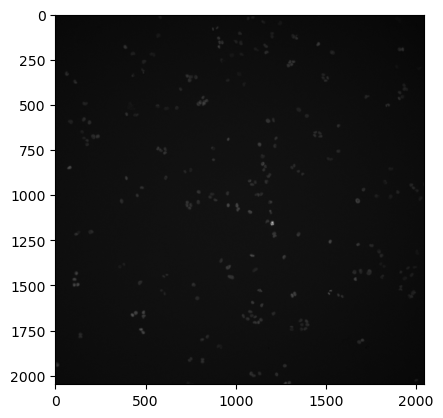

In [15]:
plt.imshow(rgb_nuc)
plt.show()

In [12]:
frame0_nuc_channel = read_nd2.get_channel_rawData(movie, 0, 0, 0)
rgb_nuc = np.dstack((frame0_nuc_channel, frame0_nuc_channel, frame0_nuc_channel))
rgb_nuc = cv2.normalize(rgb_nuc, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
master_cells = do_watershed(rgb_nuc)


numcells = []
for i in range(1, len(site0)):
    frame0_nuc_channel = read_nd2.get_channel_rawData(movie, 0, i, 0)
    curr_frame = read_nd2.get_channel_rawData(movie, 0, i, 0)
    curr_frame = np.dstack((frame0_nuc_channel, frame0_nuc_channel, frame0_nuc_channel))
    curr_frame = cv2.normalize(curr_frame, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    # rgb_nuc = np.dstack((frame0_nuc_channel, frame0_nuc_channel, frame0_nuc_channel))

    # rgb_nuc = cv2.normalize(rgb_nuc, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    #curr_frame = read_nd2.get_channel_rawData(movie, 0, i, 0)
    #curr_frame = np.dstack((frame0_nuc_channel, frame0_nuc_channel, frame0_nuc_channel))
    master_cells = link_next_frame(master_cells, curr_frame)
    numcells.append(len(master_cells))

In [13]:
for cell in master_cells[:5]:
    print(cell)

Cell: Coords=[(1021, 1023), (1000, 1070), (1002, 1082), (1006, 1079), (1000, 1075), (1003, 1074)], Num Contours=6
Cell: Coords=[(1458, 4), (1448, 2), (1441, 3), (1433, 4), (1428, 3), (1443, 12)], Num Contours=6
Cell: Coords=[(1070, 21), (1012, 97), (1009, 102), (1012, 150), (1009, 104), (1006, 104), (1006, 104), (1012, 149), (1004, 104), (1012, 149), (1004, 104)], Num Contours=11
Cell: Coords=[(897, 76), (888, 77), (880, 70), (879, 67), (879, 71), (877, 75)], Num Contours=6
Cell: Coords=[(875, 83), (867, 78), (865, 72), (865, 72), (866, 73), (865, 76)], Num Contours=6


In [ ]:
# read in all images
movie = read_nd2.read_nd2("../doc/WellD01_ChannelmIFP,mCherry,YFP_Seq0000.nd2")
# movie = read_nd2.read_nd2("../doc/WellA01_ChannelmIFP,mCherry,YFP_Seq0000-big.nd2")
site0 = read_nd2.get_site_data(movie, 0)
frame0 = read_nd2.get_frame_data(movie, 0, 0)

# frame0_nuc_channel = read_nd2.get_channel_rawData(movie, 0, 0, 0)
# # print(frame0_nuc_channel.shape)
# rgb_nuc = np.dstack((frame0_nuc_channel, frame0_nuc_channel, frame0_nuc_channel))

# rgb_nuc = cv2.normalize(rgb_nuc, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# master_cells = do_watershed(rgb_nuc)

#loop over remaining frames and do track linking
# numcells = []
for i in range(1, len(site0)):
    frame0_nuc_channel = read_nd2.get_channel_rawData(movie, 0, i, 0)
    curr_frame = read_nd2.get_channel_rawData(movie, 0, i, 0)
    curr_frame = np.dstack((frame0_nuc_channel, frame0_nuc_channel, frame0_nuc_channel))
    curr_frame = cv2.normalize(rgb_nuc, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    # rgb_nuc = np.dstack((frame0_nuc_channel, frame0_nuc_channel, frame0_nuc_channel))

    # rgb_nuc = cv2.normalize(rgb_nuc, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    #curr_frame = read_nd2.get_channel_rawData(movie, 0, i, 0)
    #curr_frame = np.dstack((frame0_nuc_channel, frame0_nuc_channel, frame0_nuc_channel))
    master_cells = link_next_frame(master_cells, rgb_nuc)
    numcells.append(len(master_cells))

In [ ]:
movie = read_nd2.read_nd2("../doc/WellA01_ChannelmIFP,mCherry,YFP_Seq0000-big.nd2")
site0 = read_nd2.get_site_data(movie, 0)
frame0 = read_nd2.get_frame_data(movie, 0, 0)

frame0_nuc_channel = read_nd2.get_channel_rawData(movie, 0, 0, 0)
print(frame0_nuc_channel.shape)
rgb_nuc = np.dstack((frame0_nuc_channel, frame0_nuc_channel, frame0_nuc_channel))

rgb_nuc = cv2.normalize(rgb_nuc, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

In [ ]:
print(range(5))

In [ ]:
movie = read_nd2.read_nd2("../doc/WellA01_ChannelmIFP,mCherry,YFP_Seq0000-big.nd2")
site0 = read_nd2.get_site_data(movie, 0)
# frame0 = read_nd2.get_frame_data(movie, 0, 0)

for i in range(5):
    frame0_nuc_channel = read_nd2.get_channel_rawData(movie, 0, frame, 0)
    rgb_nuc = np.dstack((frame0_nuc_channel, frame0_nuc_channel, frame0_nuc_channel))

    rgb_nuc = cv2.normalize(rgb_nuc, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    plt.imshow(rgb_nuc)
    plt.show()
    plt.pause(.5)

# for frame in range(5):
#     framenuc = read_nd2.get_frame_data(movie, 0, frame)
#     rgb_nuc = np.dstack((framenuc, framenuc, framenuc))
#     rgb_nuc = cv2.normalize(rgb_nuc, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

#     plt.imshow(rgb_nuc)
#     plt.show()
#     plt.pause(1)

In [ ]:
movie = read_nd2.read_nd2("../doc/WellA01_ChannelmIFP,mCherry,YFP_Seq0000-big.nd2")
site0 = read_nd2.get_site_data(movie, 0)

# Create an initial plot
fig, ax = plt.subplots()
img = ax.imshow(rgb_nuc)
plt.show()

# Introduce a time lag (e.g., 0.5 seconds)
plt.pause(0.5)

# Iterate over the remaining frames
for frame in range(1, 100):
    frame0_nuc_channel = read_nd2.get_channel_rawData(movie, 0, frame, 0)
    rgb_nuc = np.dstack((frame0_nuc_channel, frame0_nuc_channel, frame0_nuc_channel))
    rgb_nuc = cv2.normalize(rgb_nuc, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # Update the existing plot with the new frame
    img.set_data(rgb_nuc)
    plt.pause(0.5)  # Introduce a time lag (0.5 seconds) between frames

# Keep the plot window open
plt.show()

In [ ]:
movie = read_nd2.read_nd2("../doc/WellA01_ChannelmIFP,mCherry,YFP_Seq0000-big.nd2")
site0 = read_nd2.get_site_data(movie, 0)

# Create an initial plot
fig, ax = plt.subplots()
img = ax.imshow(rgb_nuc)

for frame in range(1, 100):
    frame0_nuc_channel = read_nd2.get_channel_rawData(movie, 0, frame, 0)
    rgb_nuc = np.dstack((frame0_nuc_channel, frame0_nuc_channel, frame0_nuc_channel))
    rgb_nuc = cv2.normalize(rgb_nuc, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    cv2.imwrite("pngs/" + str(frame) + ".png", rgb_nuc)


In [ ]:
os.getcwd()

In [ ]:
os.chdir("/Users/grace/Desktop/CSCI6118/Cell-Tracking/src/pngs")
files = os.listdir()
print(files)

import imageio
images = []
for file in files:
    images.append(imageio.imread(file))
    print(imageio.imread(file).shape)
    print(file)
imageio.mimsave('../testmovieohno.gif', images, duration=0.2)

In [ ]:
# print(numcells)

# # combine cell data into one 2D array
# # Define the dtype for the 'tracks' array
# dtype = [('cell', 'U10'), ('x', int), ('y', int), ('t', int)]

# # Create an empty array with the specified dtype
# tracks = np.empty((len(master_cells) * 181, 4), dtype=dtype)

# for i in range(0, len(master_cells)):
#     for j in range(0, 181):
#         if type(master_cells[i].coords[j][0]) is tuple:
#             print(str(i) + ", " + str(j))
#         tracks[i*181][0] = str(i)
#         tracks[i*181][1] = master_cells[i].coords[j][0]
#         tracks[i*181][2] = master_cells[i].coords[j][1]
#         tracks[i*181][3] = j

# np.savetxt(fname = "../tracks.csv",  X = tracks, delimiter=",", fmt='%s,%d,%d,%d')


dtype = [('cell', 'U10'), ('x', int), ('y', int), ('t', int)]

# Create an empty array with the specified dtype
tracks = np.empty((len(master_cells) * 181 + 1,), dtype=dtype)

# Populate the 'tracks' array
tracks['cell'][1:] = [str(i) for i in range(len(master_cells)) for _ in range(181)]
tracks['x'][1:] = [int(master_cells[i].coords[j][0]) for i in range(len(master_cells)) for j in range(181)]
tracks['y'][1:] = [int(master_cells[i].coords[j][1]) for i in range(len(master_cells)) for j in range(181)]
tracks['t'][1:] = [j for _ in range(len(master_cells)) for j in range(181)]

# Convert the structured numpy array to a Pandas DataFrame
df = pd.DataFrame(tracks[1:])

# Save the DataFrame to a CSV file
df.to_csv("../tracks.csv", index=False)


In [ ]:
for cell in master_cells:
    print(cell)